In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from glob import glob

In [5]:
from npc_sync.sync import SyncDataset

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [26]:
%matplotlib widget

### Get meta data from files

In [4]:
data_folder = r'P:\mouse720762\aw_iso_2024-02-21_10-32-01\experiment1\recording1'
# data_folder = r"E:\eeg_pilot\mouse496220\audio_vis4_2020-06-18_13-49-17\recording1" ## sync analog SR=10000
# data_folder = r"E:\eeg_pilot\mouse505550\pilot1_2020-03-02_10-08-51\recording1" ## sync analog SR=1000

In [8]:
print(exp.mouse)
# print(exp.sample_rate)
print(exp.computerID)

724058
W10DT05491


### Load sync dataset

In [6]:
sync_file = sorted(glob(data_folder + '/*.sync', recursive=True))[0]
print(sync_file)

P:\mouse720762\aw_iso_2024-02-21_10-32-01\experiment1\recording1\mouse720762240221103145.sync


In [7]:
sync_dataset = SyncDataset(sync_file)

In [8]:
print(sync_dataset.line_labels)

['barcodes', 'opto_sync', 'frames', 'behavior_sweep', 'photodiode', 'sweep', '', 'behavior_vsync', 'eyetracking', 'behavior', 'rotA', 'rotB', 'estim_sync', 'estim_sweep', '', '', '', 'opto_sweep', 'opto_trial', '', '', '', '', '', '', '', '', '', '', '', '', '']


In [9]:
target_sample_rate = 100 # Hz

## Analysis for analog wheel encoder

### Math to convert to linear velocity

#### Remove peaks from linear velocity

## Analysis for digital wheel encoder

In [10]:
print(sync_dataset.sample_freq)

100000.0


In [11]:
print(sync_dataset.sample_freq/target_sample_rate)

1000.0


In [12]:
WHEEL_RADIUS = 8.25 # cm
COUNT_WINDOW = int(sync_dataset.sample_freq/target_sample_rate) # sample window to count edges over
subject_position = 3/4

In [14]:
Afalling = sync_dataset.get_falling_edges('rotA')
Bfalling = sync_dataset.get_falling_edges('rotB')
sync_samples = sync_dataset.get_all_times(units='samples')

In [15]:
print(Afalling[0:10])
print(Afalling[-6:]/sync_dataset.sample_freq)

[  359  2170  4108  6213  8523 10999 13522 16037 18494 20860]
[3816.33265 3816.86084 3817.81025 3818.30211 3819.38664 3822.13002]


In [16]:
print(len(Afalling))
print(len(Bfalling))
print(len(sync_samples))

158568
158568
2062675


In [17]:
unique_list = []
dup_list = []
for val in Afalling:
    if any((Bfalling >= val-5) & (Bfalling <= val+5)):
        dup_list.append(val)
#         continue
    else: unique_list.append(val)
Afalling_pruned = np.array(unique_list)
Afalling_dups = np.array(dup_list)
print(len(Afalling_pruned))

158568


In [18]:
# Create count windows for histogram.
sample_windows = np.arange(-COUNT_WINDOW, sync_samples[-1], COUNT_WINDOW, dtype='int')
edge_count, x = np.histogram(Afalling_pruned, bins=sample_windows)

In [19]:
print(len(edge_count))

725449


In [20]:
print(edge_count[1000:1010])

[1 0 0 0 1 0 0 1 0 0]


In [21]:
print(sample_windows[0:10])

[-1000     0  1000  2000  3000  4000  5000  6000  7000  8000]


linear velocity = angular velocity * radius (if angular velocity is in radians/s)
<br>linear_velocity = dx_rad * target_sample_rate * (wheel_radius * subject_position) # cm/s
<br>angular velocity = 2 x pi x revolutions/s

In [22]:
# speed = (edge_count / 128 (edges/rev)) / d(time) * radius * 2pi (rad/rev)
linear_speed = (edge_count * WHEEL_RADIUS * subject_position * sync_dataset.sample_freq * 2 * np.pi) / (128 * COUNT_WINDOW)

In [23]:
# smooth speed with simple mean smoothing filter
smooth_speed = np.zeros_like(linear_speed)
k = 20 # filter window is actually k*2+1
for i in range(k, len(linear_speed)-k-1):
    smooth_speed[i] = np.mean(linear_speed[i-k:i+k]) # each point is the average of k surrounding points

In [24]:
timestamps = sample_windows[1:] / sync_dataset.sample_freq

Text(0.5, 0, 'time (s)')

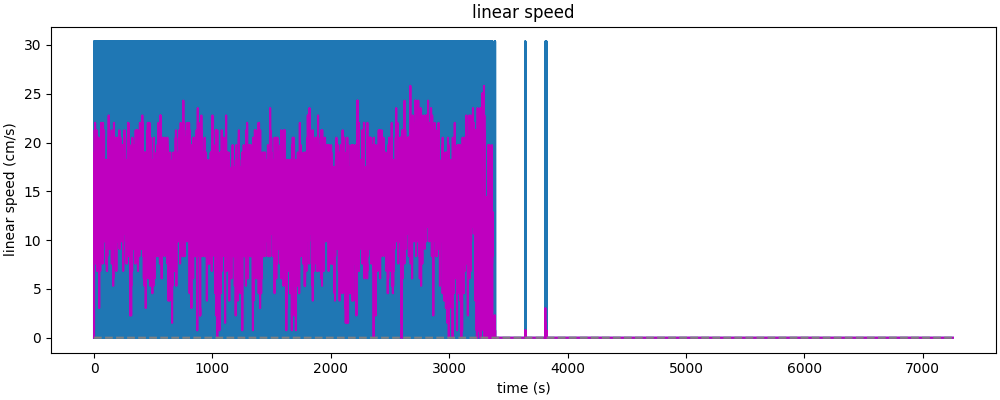

In [30]:
fig, ax = plt.subplots(figsize=(10, 4), constrained_layout=True)
ax.plot(timestamps, linear_speed)
ax.plot(timestamps, smooth_speed, 'm')
ax.plot(timestamps, np.zeros_like(linear_speed), "--", color="gray")
ax.set_title('linear speed')
ax.set_ylabel('linear speed (cm/s)')
ax.set_xlabel('time (s)')